<a href="https://colab.research.google.com/github/flaviorosso/market-breadth-analysis/blob/main/Market_Breadth_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Introduction***

Financial markets are fundamentally driven by human emotions, particularly greed and fear. When a large majority of assets—***around 90%***—are trading ***above*** their ***moving averages***, it often signals that the crowd is overly optimistic, believing in endless gains. Historically, such extreme optimism tends to appear near market tops. Conversely, when ***about 90%*** of assets are trading ***below*** their ***moving averages***, it reflects widespread pessimism. This exaggerated fear can often coincide with market bottoms, presenting potential opportunities for recovery.

This notebook was developed to analyze ***Market Breadth***, aiming to better understand the participation and collective strength of assets during upward or downward movements. The code is structured in a modular way to allow quick adjustments and clear interpretation of results. A key element is the variable ***ma = 17***, which defines the period of the moving average used in the calculations.

This variable was intentionally left as an adjustable fine-tuning parameter, enabling the user to modify its value according to the dataset under analysis or the desired level of data smoothing. By testing different window sizes, the user can identify the most suitable setting for each context.

The main purpose of this notebook is to provide a flexible, practical, and transparent tool to explore market data and uncover collective behavioral patterns beyond the simple observation of market indexes.

[*********************100%***********************]  96 of 96 completed
[*********************100%***********************]  1 of 1 completed


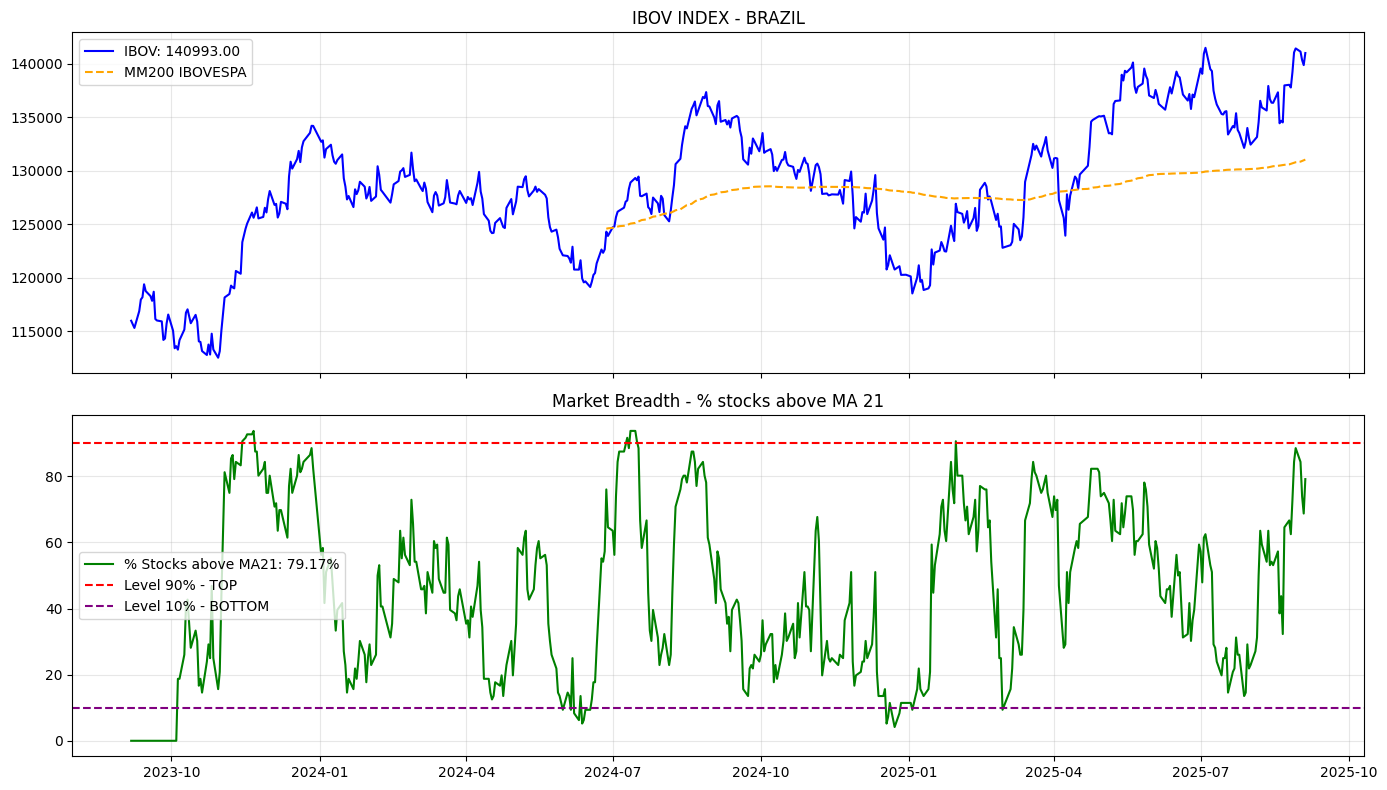

In [24]:
# Market Breadth index to analyse if the market is approaching TOP or BOTTOM
# First experiment IBOVESPA B3 Brasil market

# --- Market Breadth IBOVESPA ---
# Flavio Rosso | Base para projeto no GitHub

!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# ------------------------------
# Parâmetros
# ------------------------------
start = (dt.datetime.today() - dt.timedelta(days=730)).strftime("%Y-%m-%d")  # últimos 2 anos
end = dt.datetime.today().strftime("%Y-%m-%d")

moving_avg_days = 21   # média móvel curta (parametrizável)
index_symbol = "^BVSP" # IBOVESPA
# Lista completa de ativos do IBOVESPA (formato yfinance com .SA)
stocks = [
    "ABEV3.SA","ALOS3.SA","ALPA4.SA","AZZA3.SA","ASAI3.SA","AURE3.SA","AZUL4.SA",
    "B3SA3.SA","BBAS3.SA","BBDC3.SA","BBDC4.SA","BBSE3.SA","BEEF3.SA","BHIA3.SA",
    "BOVA11.SA","BPAC11.SA","BRAP4.SA","BRFS3.SA","BRKM5.SA","CASH3.SA","CBAV3.SA",
    "MOTV3.SA","CMIG4.SA","CMIN3.SA","COGN3.SA","CPFE3.SA","CPLE6.SA","CSAN3.SA",
    "CSMG3.SA","CSNA3.SA","CVCB3.SA","CYRE3.SA","DIRR3.SA","DXCO3.SA","ECOR3.SA",
    "EGIE3.SA","ELET3.SA","ELET6.SA","EMBR3.SA","ENEV3.SA","ENGI11.SA","EQTL3.SA",
    "EZTC3.SA","FLRY3.SA","GGBR4.SA","GMAT3.SA","GOAU4.SA","HAPV3.SA","HYPE3.SA",
    "IGTI11.SA","IRBR3.SA","ITSA4.SA","ITUB4.SA","KLBN11.SA","LREN3.SA","LWSA3.SA",
    "MDIA3.SA","MGLU3.SA","MOVI3.SA","MRFG3.SA","MRVE3.SA","MULT3.SA","PCAR3.SA",
    "PETR3.SA","PETR4.SA","PETZ3.SA","PRIO3.SA","PSSA3.SA","RADL3.SA",
    "RAIL3.SA","RAIZ4.SA","RDOR3.SA","RECV3.SA","RENT3.SA","BRAV3.SA","SANB11.SA",
    "SBSP3.SA","SIMH3.SA","SLCE3.SA","SMAL11.SA","SMTO3.SA","STBP3.SA","SUZB3.SA",
    "TAEE11.SA","TIMS3.SA","TOTS3.SA","ISAE4.SA","UGPA3.SA","USIM5.SA","VALE3.SA",
    "VAMO3.SA","VBBR3.SA","VIVA3.SA","VIVT3.SA","WEGE3.SA","YDUQ3.SA"
]

# Obs: lista completa de ativos 05/09/2025

# ------------------------------
# Download dos dados
# ------------------------------
data = yf.download(stocks, start=start, end=end, auto_adjust=False)["Close"]
index_data = yf.download(index_symbol, start=start, end=end, auto_adjust=False)["Close"]

# ------------------------------
# Cálculo das médias móveis e breadth
# ------------------------------
mm = data.rolling(window=moving_avg_days).mean()

# Sinal: 1 se preço > média móvel, 0 caso contrário
signals = (data > mm).astype(int)

# Indicador breadth = % de ações acima da média
breadth = signals.mean(axis=1) * 100

# IBOVESPA com MM200
index_ma200 = index_data.rolling(window=200).mean()

import matplotlib.pyplot as plt

# ------------------------------
# Plotagem
# ------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- IBOVESPA ---
if isinstance(index_data, pd.DataFrame):
    col_ibov = index_data.columns[0]  # ajuste se necessário
    ibov_series = index_data[col_ibov]
else:
    ibov_series = index_data

last_ibov = ibov_series.iloc[-1]
ax1.plot(ibov_series, label=f"IBOV: {last_ibov:.2f}", color="blue")
ax1.plot(index_ma200, label="MM200 IBOVESPA", color="orange", linestyle="--")
ax1.set_title("IBOV INDEX - BRAZIL")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Market Breadth ---
last_breadth = breadth.iloc[-1]
ax2.plot(breadth, label=f"% Stocks above MA{moving_avg_days}: {last_breadth:.2f}%", color="green")
ax2.axhline(90, color="red", linestyle="--", label="Level 90% - TOP")
ax2.axhline(10, color="purple", linestyle="--", label="Level 10% - BOTTOM")
ax2.set_title(f"Market Breadth - % stocks above MA {moving_avg_days}")
ax2.legend(loc='center left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
